In [1]:
import random
import numpy as np
from game import Game, Move, Player
from copy import deepcopy
from tqdm import tqdm
import multiprocessing

In [2]:
class Dummy_Game(object):
    def __init__(self) -> None:
        self._board = np.ones((5, 5), dtype=np.uint8) * -1
        self.current_player_idx = 1

    def get_board(self): return self._board

    def single_move(self, board, from_pos, move, player_id):
        self._board = deepcopy(board)
        self.current_player_idx = player_id
        ok = self.__move(from_pos, move, player_id)
        return deepcopy(self._board), ok
    
    def check_winner_board(self, board):
        self._board = board
        return self.check_winner()

    def check_winner(self) -> int:
        for x in range(self._board.shape[0]):
            if self._board[x, 0] != -1 and all(self._board[x, :] == self._board[x, 0]): return self._board[x, 0]
        for y in range(self._board.shape[1]):
            if self._board[0, y] != -1 and all(self._board[:, y] == self._board[0, y]): return self._board[0, y]
        if self._board[0, 0] != -1 and all([self._board[x, x] for x in range(self._board.shape[0])] == self._board[0, 0]): return self._board[0, 0]
        if self._board[0, -1] != -1 and all([self._board[x, -(x + 1)] for x in range(self._board.shape[0])] == self._board[0, -1]): return self._board[0, -1]
        return -1

    def __move(self, from_pos: tuple[int, int], slide: Move, player_id: int) -> bool:
        if player_id > 2: return False
        prev_value = deepcopy(self._board[(from_pos[1], from_pos[0])])
        acceptable = self.__take((from_pos[1], from_pos[0]), player_id)
        if acceptable:
            acceptable = self.__slide((from_pos[1], from_pos[0]), slide)
            if not acceptable: self._board[(from_pos[1], from_pos[0])] = deepcopy(prev_value)
        return acceptable

    def __take(self, from_pos: tuple[int, int], player_id: int) -> bool:
        acceptable: bool = ((from_pos[0] == 0 and from_pos[1] < 5) or (from_pos[0] == 4 and from_pos[1] < 5) or (from_pos[1] == 0 and from_pos[0] < 5) or (from_pos[1] == 4 and from_pos[0] < 5)) and (self._board[from_pos] < 0 or self._board[from_pos] == player_id)
        if acceptable: self._board[from_pos] = player_id
        return acceptable

    def __slide(self, from_pos: tuple[int, int], slide: Move) -> bool:
        SIDES = [(0, 0), (0, 4), (4, 0), (4, 4)]
        if from_pos not in SIDES:
            acceptable_top: bool = from_pos[0] == 0 and (slide == Move.BOTTOM or slide == Move.LEFT or slide == Move.RIGHT)
            acceptable_bottom: bool = from_pos[0] == 4 and (slide == Move.TOP or slide == Move.LEFT or slide == Move.RIGHT)
            acceptable_left: bool = from_pos[1] == 0 and (slide == Move.BOTTOM or slide == Move.TOP or slide == Move.RIGHT)
            acceptable_right: bool = from_pos[1] == 4 and (slide == Move.BOTTOM or slide == Move.TOP or slide == Move.LEFT)
        else:
            acceptable_top: bool = from_pos == (0, 0) and (slide == Move.BOTTOM or slide == Move.RIGHT)
            acceptable_left: bool = from_pos == (4, 0) and (slide == Move.TOP or slide == Move.RIGHT)
            acceptable_right: bool = from_pos == (0, 4) and (slide == Move.BOTTOM or slide == Move.LEFT)
            acceptable_bottom: bool = from_pos == (4, 4) and (slide == Move.TOP or slide == Move.LEFT)
        acceptable: bool = acceptable_top or acceptable_bottom or acceptable_left or acceptable_right
        if acceptable:
            piece = self._board[from_pos]
            if slide == Move.LEFT:
                for i in range(from_pos[1], 0, -1): self._board[(from_pos[0], i)] = self._board[(from_pos[0], i - 1)]
                self._board[(from_pos[0], 0)] = piece
            elif slide == Move.RIGHT:
                for i in range(from_pos[1], self._board.shape[1] - 1, 1): self._board[(from_pos[0], i)] = self._board[(from_pos[0], i + 1)]
                self._board[(from_pos[0], self._board.shape[1] - 1)] = piece
            elif slide == Move.TOP:
                for i in range(from_pos[0], 0, -1): self._board[(i, from_pos[1])] = self._board[(i - 1, from_pos[1])]
                self._board[(0, from_pos[1])] = piece
            elif slide == Move.BOTTOM:
                for i in range(from_pos[0], self._board.shape[0] - 1, 1): self._board[(i, from_pos[1])] = self._board[(i + 1, from_pos[1])]
                self._board[(self._board.shape[0] - 1, from_pos[1])] = piece
        return acceptable

In [3]:
border = []
for i in range(5):
    for j in range(5):
        if i == 0 or i == 4 or j == 0 or j == 4:
            border.append((i, j))
BORDER = (list(set(border)))
print(len(BORDER))

def tile_to_moves(tile):
    possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
        
    if tile[0] == 0: possible_moves.remove(Move.LEFT)
    if tile[0] == 4: possible_moves.remove(Move.RIGHT)
    if tile[1] == 0: possible_moves.remove(Move.TOP)
    if tile[1] == 4: possible_moves.remove(Move.BOTTOM)

    return possible_moves

tile_moves = {tile: tile_to_moves(tile) for tile in BORDER}

ALL_MOVES = []
for tile in BORDER:
    possible_moves = tile_moves[tile]
    for move in possible_moves: ALL_MOVES.append((tile, move))
N_ALL = len(ALL_MOVES)

class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        from_pos = random.choice(BORDER)
        while game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx: from_pos = random.choice(BORDER)

        possible_moves = tile_moves[from_pos]
        
        move = random.choice(possible_moves)

        return from_pos, move

16


In [4]:
## state can be represented as two numbers if 0,1 are considered as bit

In [5]:
import numpy as np

def state_to_board(state):
    binary_string = format(state, '050b')
    binary_array = np.array(list(map(int, binary_string))).reshape(2, 5, 5)

    board = np.zeros((5, 5), dtype=int)
    board[binary_array[0] == 1] = -1
    board[binary_array[1] == 1] = 1

    return board

def board_to_state(board):
    binary_array = np.zeros((2, 5, 5), dtype=int)
    
    binary_array[0][board == -1] = 1
    binary_array[1][board == 1] = 1

    binary_string = ''.join(map(str, binary_array.flatten()))
    return int(binary_string, 2)



rand_board = np.random.choice([-1, 0, 1], size=(5, 5), replace=True)
print('Board:')
print(rand_board)

rand_state = board_to_state(rand_board)
rand_board = state_to_board(rand_state)

print('\nState:')
print(rand_state)
print('\nBoard:')
print(state_to_board(rand_state))

Board:
[[ 1  1  0 -1  1]
 [ 0  0 -1 -1  1]
 [ 0  0 -1  1  1]
 [ 0  0 -1  1  0]
 [ 0  0  1  1  0]]

State:
77107574115398

Board:
[[ 1  1  0 -1  1]
 [ 0  0 -1 -1  1]
 [ 0  0 -1  1  1]
 [ 0  0 -1  1  0]
 [ 0  0  1  1  0]]


In [6]:
dict_rot = {
    (Move.TOP, 1): Move.LEFT,
    (Move.TOP, 2): Move.BOTTOM,
    (Move.TOP, 3): Move.RIGHT,
    (Move.BOTTOM, 1): Move.RIGHT,
    (Move.BOTTOM, 2): Move.TOP,
    (Move.BOTTOM, 3): Move.LEFT,
    (Move.LEFT, 1): Move.TOP,
    (Move.LEFT, 2): Move.RIGHT,
    (Move.LEFT, 3): Move.BOTTOM,
    (Move.RIGHT, 1): Move.BOTTOM,
    (Move.RIGHT, 2): Move.LEFT,
    (Move.RIGHT, 3): Move.TOP,
}

dict_flip = {
    Move.TOP: Move.TOP,
    Move.BOTTOM: Move.BOTTOM,
    Move.LEFT: Move.RIGHT,
    Move.RIGHT: Move.LEFT,
}

#rot_orario: (3, 4) -> (4, 1) -> (1, 0) -> (0, 3) -> (3, 4)
#: (xi, yi) -> (yi, 4 - xi)
#rot_anti_orario: (3, 4) -> (0, 3) -> (1, 0) -> (4, 1) -> (3, 4)
#: (xi, yi) -> (4 - yi, xi)

def rot(n_rot):
    def rot_n(from_pos, move):
        for _ in range(n_rot):
            from_pos = 4 - from_pos[1], from_pos[0]
        return from_pos, dict_rot[(move, n_rot)]
    return rot_n

def flip(from_pos, move):
    from_pos = 4 - from_pos[0], from_pos[1]
    return from_pos, dict_flip[move]

def flip_rot(n_rot):
    def flip_rot_n(from_pos, move):
        from_pos, move = rot(n_rot)(from_pos, move)
        return flip(from_pos, move)
    return flip_rot_n

rot1 = rot(1)
rot2 = rot(2)
rot3 = rot(3)
flip_rot1 = flip_rot(1)
flip_rot2 = flip_rot(2)
flip_rot3 = flip_rot(3)

verse_simmetries = [
    rot3,
    rot2,
    rot1,
    flip,
    flip_rot3,
    flip_rot2,
    flip_rot1,
]

inverse_simmetries = [
    rot1,
    rot2,
    rot3,
    flip,
    flip_rot1,
    flip_rot2,
    flip_rot3,
]

def check_simmetries(board, state_list):

    if tuple(board.flatten()) in state_list: return tuple(board.flatten()), None

    R1 = np.rot90(board)
    if tuple(R1.flatten()) in state_list: return tuple(R1.flatten()), 0

    R2 = np.rot90(R1)
    if tuple(R2.flatten()) in state_list: return tuple(R2.flatten()), 1

    R3 = np.rot90(R2)
    if tuple(R3.flatten()) in state_list: return tuple(R3.flatten()), 2
    
    F = np.fliplr(board)
    if tuple(F.flatten()) in state_list: return tuple(F.flatten()), 3
    
    FR1 = np.rot90(F)
    if tuple(FR1.flatten()) in state_list: return tuple(FR1.flatten()), 4
    
    FR2 = np.rot90(FR1)
    if tuple(FR2.flatten()) in state_list: return tuple(FR2.flatten()), 5
    
    FR3 = np.rot90(FR2)
    if tuple(FR3.flatten()) in state_list: return tuple(FR3.flatten()), 6
    
    return None

MOVES_SIMMETRIES = {} #(id_move, id_simmetry) -> id_move

for id_move in range(len(ALL_MOVES)):
    from_pos, move = ALL_MOVES[id_move]

    for id_simmetry in range(len(inverse_simmetries)):

        idx = None
        for i in range(len(ALL_MOVES)):
            if ALL_MOVES[i] == inverse_simmetries[id_simmetry](from_pos, move):
                idx = i
                break
        
        MOVES_SIMMETRIES[(id_move, id_simmetry)] = i

print(len(MOVES_SIMMETRIES))
print(len(ALL_MOVES) * 7)

308
308


In [7]:
## to discard for the amount of possible states

## to change with a check that control if a state already exist, if yes retreive the q-values, if not it creates a random q-value for 
## each move for that state, if legal


#import itertools
#from tqdm import tqdm
#MATRIX_SIZE = 5
#
#count_all = 0
#for s in itertools.product([-1, 0, 1], repeat= pow(MATRIX_SIZE, 2)): count_all += 1
#print(count_all)
#print('--------------')
#
#states_list = []
#
#for s in tqdm(itertools.product([-1, 0, 1], repeat= pow(MATRIX_SIZE, 2))):
#    if check_simmetries(np.array(s).reshape(MATRIX_SIZE, MATRIX_SIZE), states_list) is None:
#        states_list.append(tuple(s))
#    
#    #if count_all % 100 == 0:
#    #    print((len(states_list), count_all))
#
#print(count_all)
#print(len(states_list))

In [8]:
def game_sim(args):

    base_board, next_to_move = args

    dummy = Dummy_Game()

    next_to_play = next_to_move
    board = deepcopy(base_board)

    winner = dummy.check_winner_board(board)
    while winner == -1:

        from_pos, move = ALL_MOVES[np.random.randint(0, N_ALL)]
        new_board, ok = dummy.single_move(board, from_pos, move, next_to_play)
        while not ok:
            from_pos, move = ALL_MOVES[np.random.randint(0, N_ALL)]
            new_board, ok = dummy.single_move(board, from_pos, move, next_to_play)

        board = new_board
        next_to_play = 1 - next_to_play

        winner = dummy.check_winner_board(board)

    if winner == 0: return 1, 0
    else: return 0, 1

class MyPlayer(Player):
    def __init__(self, eps= 2, alpha= 1, simulations_on_new= 1, base_until_move_change= 10) -> None:
        super().__init__()

        self.eps = eps
        self.alpha = alpha
        self.simulation_on_new = simulations_on_new

        self.states_dict = {}

        self.dummy = Dummy_Game()

        self.train_init()

        self.base_until_move_change = base_until_move_change
        self.last_pos_move = None
        self.until_move_change = self.base_until_move_change
        self.n_move_changes = 0

        self.tot_count = 0
        self.random_count = 0

    def get_random_count(self): return self.random_count
    def get_tot_count(self): return self.tot_count
    def get_n_move_changes(self): return self.n_move_changes
    def reset_counters(self):
        self.n_move_changes = 0
        self.tot_count = 0
        self.random_count = 0
        self.until_move_change = self.base_until_move_change

    def expansion(self, board, next_to_move):

        # get legal childrens of a node, child: (move_to_child, child_state)

        children = []
        for from_pos, move in ALL_MOVES:
            new_board, ok = self.dummy.single_move(board, from_pos, move, next_to_move)
            if ok:
                new_state = tuple(new_board.flatten())
                
                ######## S
                simmetry = check_simmetries(new_board, self.states_dict)
                if simmetry is None: id_simmetry = None
                else: new_state, id_simmetry = simmetry
                ######## S

                children.append(((from_pos, move), new_state))

        return children
    
    def simulation(self, base_board, next_to_move):

        # random simulation from a certain state to the end, return outcomes

        win_0 = 0
        win_1 = 0

        num_processors = multiprocessing.cpu_count()
        num_processors = 1

        for _ in range(self.simulation_on_new):

            pool = multiprocessing.Pool(processes=num_processors)

            # Use pool.map to call ses in parallel
            results = pool.map(game_sim, (base_board, next_to_move))

            pool.close()
            pool.join()

            #results = [game_sim(base_board, next_to_move)]

            for new_win_0, new_win_1 in results:
                win_0 += new_win_0
                win_1 += new_win_1
        
        return win_0, win_1, self.simulation_on_new
    
    def update(self, states_to_update, win_0, win_1, count):

        player_responsible = 0

        ##### M
        #n_move = 0
        ##### M

        for state in states_to_update:
            player_responsible = 1 - player_responsible

            ##### M
            #if player_responsible == 1: n_move += 1
            #amount = win_0 * n_move if player_responsible == 0 else win_1 * n_move
            amount = win_0 if player_responsible == 0 else win_1
            ##### M

            if state in self.states_dict:
                self.states_dict[state][0] += amount
                self.states_dict[state][1] += count
            else: self.states_dict[state] = [amount, count, []]

    ##### A
    def evaluate_board(self, board):

        player_id = 1 if sum(sum(board < 0)) % 2 == 0 else 0 # (pari -> 1 ha giocato, dispari -> 0 ha giocato), si valuta chi ha appena giocato

        bonus = 0
        diag_a_player = 0
        diag_a_enemy = 0
        diag_b_player = 0
        diag_b_enemy = 0
        for i in range(5):
            
            line = board[i, :]
            bonus += pow(sum(line == player_id), 2) - pow(sum(line == 1 - player_id), 2)
            #bonus += sum(line == player_id) - sum(line == 1 - player_id)

            line = board[:, i]
            bonus += pow(sum(line == player_id), 2) - pow(sum(line == 1 - player_id), 2)
            #bonus += sum(line == player_id) - sum(line == 1 - player_id)
            
            if board[i, i] == player_id: diag_a_player += 1
            elif board[i, i] == 1 - player_id: diag_a_enemy += 1
            
            if board[i, 4-i] == player_id: diag_b_player += 1
            elif board[i, 4-i] == 1 - player_id: diag_b_enemy += 1

        bonus += pow(diag_a_player, 2) - pow(diag_a_enemy, 2)
        #bonus += diag_a_player - diag_a_enemy
            
        bonus += pow(diag_b_player, 2) - pow(diag_b_enemy, 2)
        #bonus += diag_b_player - diag_b_enemy

        #bonus += 15 if board[2, 2] == current_player else -16 # the center of the board is used in four winning combination

        return bonus / 300
    ##### A

    def selection(self, current_state, path= None):

        training = path is not None
        #if not training: path = []

        if current_state not in self.states_dict:
            if training:
                print("STATE NOT IN STATES_DICT -> IT SHOULDN'T HAPPEN")
                return None
            else: return None

        parent = self.states_dict[current_state]
        parent_count = parent[1]
        childrens = parent[2]

        if len(childrens) == 0: return None

        ##### R
        if training:
            if np.random.random() < self.eps:
                return childrens[np.random.randint(0, len(childrens))][1]
        ##### R
            
        has_childs = []
        values = []
        board = np.array(current_state).reshape(5, 5)
        for _, child_state in childrens:
            #if child_state not in path:
                child = self.states_dict[child_state]
                wi = child[0]
                ci = child[1]
                has_childs.append(len(child[2]) > 0)

                if training: values.append((wi / ci))# + np.sqrt(self.eps * np.log(parent_count) / ci))   ##### not R
                else: values.append(wi / ci)

                ##### A
                values[-1] += self.alpha * self.evaluate_board(np.array(child_state).reshape(5, 5))
                ##### A

        best_id = np.argmax(values)

        if training: return childrens[best_id][1]
        else: return childrens[best_id][0]

    def train_init(self):

        starting_board = np.ones((5, 5), dtype= np.uint8) * -1

        win_0, win_1, count = self.simulation(starting_board, 0)

        starting_state = tuple(starting_board.flatten())

        self.update([starting_state], win_0, win_1, count)
    
    def train_wrapper(self, training_epochs= 10):

        max_depth = 0

        for _ in tqdm(range(training_epochs)):
        #for _ in range(training_epochs):

            
            board = np.ones((5, 5), dtype= np.uint8) * -1
            state = tuple(board.flatten())
            next_to_move = 0

            path = [state]

            chosen = self.selection(state, path= path)
            while chosen is not None:
                path.append(chosen)
                next_to_move = 1 - next_to_move
                chosen = self.selection(chosen, path= path)
            chosen = path[-1]

            #print('==================================================')
            #print('==================================================')
            #print(len(path))
            #print(next_to_move)
            #print('---------')

            if len(path) > max_depth: max_depth = len(path)

            board = np.array(chosen).reshape(5, 5)

            children = self.expansion(board, next_to_move)

            for child in children:
                new_state = child[1]
                new_board = np.array(new_state).reshape(5, 5)
                win_0, win_1, count = self.simulation(new_board, 1 - next_to_move)
                new_path = deepcopy(path)
                new_path.append(new_state)
                self.update(new_path, win_0, win_1, count)
                self.states_dict[chosen][2].append(child)

        print(f'max depth: {max_depth}')
        print(f'states explored: {len(self.states_dict)}')

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        self.tot_count += 1

        board = game.get_board()
        state = tuple(board.flatten())

        ######## S
        simmetry = check_simmetries(board, self.states_dict)
        if simmetry is not None: state, id_simmetry = simmetry
        else: id_simmetry = None
        ######## S

        pos_move = self.selection(state)

        ######## S
        if id_simmetry is not None and pos_move is not None: pos_move = inverse_simmetries[id_simmetry](pos_move[0], pos_move[1])
        ######## S

        rand = False
        if pos_move is None: rand = True
        elif pos_move == self.last_pos_move:
            self.until_move_change -= 1
            if self.until_move_change == 0:
                rand = True
                self.until_move_change = self.base_until_move_change
        else: self.last_pos_move = pos_move

        if rand:
            self.random_count += 1
            board = game.get_board()
            player_id = game.current_player_idx
            from_pos, move = ALL_MOVES[np.random.randint(0, N_ALL)]
            while board[from_pos[1], from_pos[0]] == 1 - player_id: from_pos, move = ALL_MOVES[np.random.randint(0, N_ALL)]
        else: from_pos, move = pos_move
        
        #print((from_pos, move))
        return from_pos, move

In [9]:
mc = MyPlayer(eps= 0.1, alpha= 2, simulations_on_new= 1)
mc.train_wrapper(100)

ThePlayer = mc

wins_first = 0
wins_second = 0
n_trials = 1

player1 = ThePlayer
player2 = RandomPlayer()

count_rand_1 = 0
count_tot_1 = 0
count_rand_2 = 0
count_tot_2 = 0

for _ in range(n_trials):
    
    g = Game()
    player1.reset_counters()
    winner = g.play(player1, player2)
    if winner == 0: wins_first += 1
    count_rand_1 += player1.get_random_count()
    count_tot_1 += player1.get_tot_count()

    g = Game()
    player1.reset_counters()
    winner = g.play(player2, player1)
    if winner == 1: wins_second += 1
    count_rand_2 += player1.get_random_count()
    count_tot_2 += player1.get_tot_count()

print(f"Player won {wins_first} / {n_trials} as first")
print(f"Player won {wins_second} / {n_trials} as second")
print(f'player played {count_tot_1 - count_rand_1} non-random moves over {count_tot_1} moves as first')
print(f'player played {count_tot_2 - count_rand_2} non-random moves over {count_tot_2} moves as second')

: 

In [75]:
mc = MyPlayer(eps= 0.25, simulations_on_new= 1)
mc.train_wrapper(1000)

ThePlayer = mc

wins_first = 0
wins_second = 0
n_trials = 1000

player1 = ThePlayer
player2 = RandomPlayer()

count_rand_1 = 0
count_tot_1 = 0
count_rand_2 = 0
count_tot_2 = 0

for _ in range(n_trials):
    
    g = Game()
    player1.reset_counters()
    winner = g.play(player1, player2)
    if winner == 0: wins_first += 1
    count_rand_1 += player1.get_random_count()
    count_tot_1 += player1.get_tot_count()

    g = Game()
    player1.reset_counters()
    winner = g.play(player2, player1)
    if winner == 1: wins_second += 1
    count_rand_2 += player1.get_random_count()
    count_tot_2 += player1.get_tot_count()

print(f"Player won {wins_first} / {n_trials} as first")
print(f"Player won {wins_second} / {n_trials} as second")
print(f'player played {count_tot_1 - count_rand_1} non-random moves over {count_tot_1} moves as first')
print(f'player played {count_tot_2 - count_rand_2} non-random moves over {count_tot_2} moves as second')

100%|██████████| 1000/1000 [01:55<00:00,  8.66it/s]


Player won 536 / 1000 as first
Player won 497 / 1000 as second
player played 1973 non-random moves over 23963 moves as first
player played 1647 non-random moves over 22977 moves as second


In [11]:
mc = MyPlayer(eps= 0.5, simulations_on_new= 1)
mc.train_wrapper(1000)

ThePlayer = mc

wins_first = 0
wins_second = 0
n_trials = 1000

player1 = ThePlayer
player2 = RandomPlayer()

count_rand_1 = 0
count_tot_1 = 0
count_rand_2 = 0
count_tot_2 = 0

for _ in range(n_trials):
    
    g = Game()
    player1.reset_counters()
    winner = g.play(player1, player2)
    if winner == 0: wins_first += 1
    count_rand_1 += player1.get_random_count()
    count_tot_1 += player1.get_tot_count()

    g = Game()
    player1.reset_counters()
    winner = g.play(player2, player1)
    if winner == 1: wins_second += 1
    count_rand_2 += player1.get_random_count()
    count_tot_2 += player1.get_tot_count()

print(f"Player won {wins_first} / {n_trials} as first")
print(f"Player won {wins_second} / {n_trials} as second")
print(f'player played {count_tot_1 - count_rand_1} non-random moves over {count_tot_1} moves as first')
print(f'player played {count_tot_2 - count_rand_2} non-random moves over {count_tot_2} moves as second')

100%|██████████| 1000/1000 [01:50<00:00,  9.05it/s]


max depth: 8
Player won 537 / 1000 as first
Player won 497 / 1000 as second
player played 1899 non-random moves over 24252 moves as first
player played 1705 non-random moves over 23836 moves as second


In [13]:
mc = MyPlayer(eps= 0.75, simulations_on_new= 1)
mc.train_wrapper(1000)

ThePlayer = mc

wins_first = 0
wins_second = 0
n_trials = 1000

player1 = ThePlayer
player2 = RandomPlayer()

count_rand_1 = 0
count_tot_1 = 0
count_rand_2 = 0
count_tot_2 = 0

for _ in range(n_trials):
    
    g = Game()
    player1.reset_counters()
    winner = g.play(player1, player2)
    if winner == 0: wins_first += 1
    count_rand_1 += player1.get_random_count()
    count_tot_1 += player1.get_tot_count()

    g = Game()
    player1.reset_counters()
    winner = g.play(player2, player1)
    if winner == 1: wins_second += 1
    count_rand_2 += player1.get_random_count()
    count_tot_2 += player1.get_tot_count()

print(f"Player won {wins_first} / {n_trials} as first")
print(f"Player won {wins_second} / {n_trials} as second")
print(f'player played {count_tot_1 - count_rand_1} non-random moves over {count_tot_1} moves as first')
print(f'player played {count_tot_2 - count_rand_2} non-random moves over {count_tot_2} moves as second')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:52<00:00,  8.91it/s]


max depth: 7
Player won 587 / 1000 as first
Player won 536 / 1000 as second
player played 2048 non-random moves over 24216 moves as first
player played 1689 non-random moves over 23489 moves as second


In [78]:
mc = MyPlayer(eps= 0.9, simulations_on_new= 1)
mc.train_wrapper(1000)

ThePlayer = mc

wins_first = 0
wins_second = 0
n_trials = 1000

player1 = ThePlayer
player2 = RandomPlayer()

count_rand_1 = 0
count_tot_1 = 0
count_rand_2 = 0
count_tot_2 = 0

for _ in range(n_trials):
    
    g = Game()
    player1.reset_counters()
    winner = g.play(player1, player2)
    if winner == 0: wins_first += 1
    count_rand_1 += player1.get_random_count()
    count_tot_1 += player1.get_tot_count()

    g = Game()
    player1.reset_counters()
    winner = g.play(player2, player1)
    if winner == 1: wins_second += 1
    count_rand_2 += player1.get_random_count()
    count_tot_2 += player1.get_tot_count()

print(f"Player won {wins_first} / {n_trials} as first")
print(f"Player won {wins_second} / {n_trials} as second")
print(f'player played {count_tot_1 - count_rand_1} non-random moves over {count_tot_1} moves as first')
print(f'player played {count_tot_2 - count_rand_2} non-random moves over {count_tot_2} moves as second')

100%|██████████| 1000/1000 [01:54<00:00,  8.70it/s]


Player won 575 / 1000 as first
Player won 498 / 1000 as second
player played 2019 non-random moves over 24104 moves as first
player played 1726 non-random moves over 23632 moves as second


In [64]:
mc = MyPlayer(eps= 0.5, simulations_on_new= 1)
mc.train_wrapper(1000)

100%|██████████| 1000/1000 [01:52<00:00,  8.89it/s]


In [65]:
ThePlayer = mc

wins_first = 0
wins_second = 0
n_trials = 1000

player1 = ThePlayer
player2 = RandomPlayer()

count_rand_1 = 0
count_tot_1 = 0
count_rand_2 = 0
count_tot_2 = 0

for _ in range(n_trials):
    
    g = Game()
    player1.reset_counters()
    winner = g.play(player1, player2)
    if winner == 0: wins_first += 1
    count_rand_1 += player1.get_random_count()
    count_tot_1 += player1.get_tot_count()

    g = Game()
    player1.reset_counters()
    winner = g.play(player2, player1)
    if winner == 1: wins_second += 1
    count_rand_2 += player1.get_random_count()
    count_tot_2 += player1.get_tot_count()

print(f"Player won {wins_first} / {n_trials} as first")
print(f"Player won {wins_second} / {n_trials} as second")
print(f'player played {count_tot_1 - count_rand_1} non-random moves over {count_tot_1} moves as first')
print(f'player played {count_tot_2 - count_rand_2} non-random moves over {count_tot_2} moves as second')

move change
move change
move change
move change
move change
move change
Player won 550 / 1000 as first
Player won 501 / 1000 as second
player played 2082 non-random moves over 23463 moves as first
player played 1787 non-random moves over 23616 moves as second


(9,)
(9,)
(9, 9)
(9, 9)


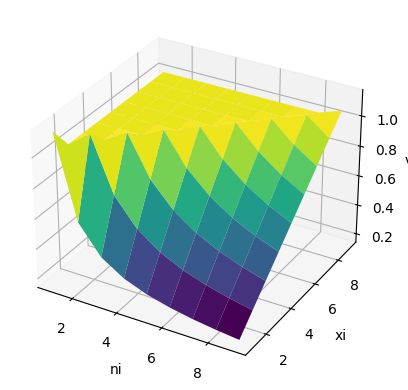

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

n = 10

ni = []
xi = []
z = []
for i in range(1, n):
    ni.append(i)
    xi.append(i)

ni = np.array(ni)
xi = np.array(xi)
print(ni.shape)
print(xi.shape)
ni, xi = np.meshgrid(ni, xi)
print(ni.shape)
print(xi.shape)
z = (xi / ni) + np.sqrt(0.01 * np.log(n) / ni)
z[xi > ni] = 1

fig = plt.figure()
ax = fig.add_subplot(111, projection= '3d')
ax.plot_surface(ni, xi, z, cmap= 'viridis')
ax.set_xlabel('ni')
ax.set_ylabel('xi')
ax.set_zlabel('val')
plt.show()